# WhatsApp network traffic analyzing project
## Part A - data cleaning

### Introduction
Although the WhatsApp software is encrypted and there is no access to the information content, we wanted to investigate whether it is possible to draw conclusions from the network traffic analysis.

We based on the idea of the academic paper ["Practical Traffic Analysis Attacks on Secure Messaging Applications"](https://www.ndss-symposium.org/wp-content/uploads/2020/02/24347-paper.pdf)

For the purpose of analyzing the traffic of WhatsApp Web, we made recordings using Wireshark of several WhatsApp groups conversations, in each group, besides the text messages, we attached specific kind of messages that we transferred between us:
- messages
- photos
- audio
- videos
- documents

We also made additional recordings of:

- Conversation (including photos, recordings, etc.) with noise - with Spotify running in the background, entering other websites, etc.

- conversation (including photos, recordings, etc.) and at the same time when one of us (simulating the attacked) makes regular use of other groups/conversations that the attacker is not a part of

We saved the recordings as a csv files in "resources" directory

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import requests
import os

In [2]:
# work_path = r"C:\Ariel codes\networks\final project\Networks_Final_Project\resources\RAW\CSV\\"

#### Redirection to the raw csv files folder

In [3]:
def getRawCsv():
    # Get the current directory where your notebook is located
    current_dir = os.getcwd()

    # Construct the path to the "resources" directory
    resources_dir = os.path.join(current_dir, '..', 'resources')

    # Construct the path to the "CLEAN" directory within "resources"
    raw_csv_dir = os.path.join(resources_dir, 'RAW/CSV/')
    return raw_csv_dir

In [4]:
#time delays between 2 consecutive messages
def add_delays(df: pd.DataFrame):
    df["Time_delay"] = (df["Time"].diff().fillna(0)).round(6)

#packets length diffs 2 consecutive messages
def add_lengths(df: pd.DataFrame):
    df["Length_diff"] = abs(df["Length"].diff()).fillna(0)


def reformat_columns(df: pd.DataFrame):
    df["No."] = df["No."].astype(float)
    df["Time"] = df["Time"].astype(float)
    df["Length"] = df["Length"].astype(float)

In [5]:
file_name = None

def load_csv(number):
    work_path = getRawCsv()
    if number == '1':
        file_name = "whatsappMessagesCSV"
        path = work_path + file_name + ".csv"
        print("---------Mixed Group (Mostly Messages)----------")
    elif number == '2':
        file_name = "whatsappImagesCSV"
        path = work_path + file_name + ".csv"
        print("---------Images----------")
    elif number == '3':
        file_name = "whatsappAudioCSV"
        path = work_path + file_name + ".csv"
        print("---------Audio----------")
    elif number == '4':
        file_name = "whatsappVideosCSV"
        path = work_path + file_name + ".csv"
        print("---------Videos----------")
    elif number == '5':
        file_name = "whatsappFilesCSV"
        path = work_path + file_name + ".csv"
        print("---------Files----------")
    elif number == '6':
        file_name = "WhatsappNoisedGroupCSV"
        path = work_path + file_name + ".csv"
        print("---------Group With Noise----------")
    elif number == '7':
        file_name = "whatsappAtteckedRegularUseCSV"
        path = work_path + file_name + ".csv"
        print("---------Attacked User Active in multiple groups (usual activity)----------")
    elif number == '8':
        file_name = "whatsappAtteckerRegularUseCSV"
        path = work_path + file_name + ".csv"
        print("--------- Attacker when Attacked User Active in multiple groups (usual activity)----------")
    
    df = pd.read_csv(path, sep=',', header=0,
                     usecols=["No.", "Time", "Source", "Destination", "Protocol", "Length", "Info"])
    reformat_columns(df)
    add_delays(df)
    add_lengths(df)
    print(df.head())
    return df, file_name

In [6]:
def plot_activity_trends(df):
    # Plot the message count over time using a line chart
    plt.figure(figsize=(15, 4))
    plt.plot(df["Time"], df["Length"], marker='o', linestyle='-')
    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Message Count and Activity Trends")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [7]:
my_country="IL"

def rows_of_probably_noisy_packets(df):
    df_copy = df.copy()  # Explicitly make a copy of the dataframe

    # Extract the first number from the "Source" column
    df_copy["FirstNumber"] = df_copy["Source"].str.split('.').str[0]

    median_lengths = df_copy.groupby('FirstNumber')['Length'].median()
    
    lots_of_packets = df_copy.groupby('FirstNumber')['Length'].count()

    # Filter the 'FirstNumber' values where the median is greater than 500
    desired_nums = list(set(median_lengths[median_lengths > 500].index.tolist()) | set(lots_of_packets[lots_of_packets > 1000].index.tolist()))
    
    wanted_ips = set()
    unwanted_ips = set()
    
    for index, row in df_copy.iterrows():
        if row['FirstNumber'] in desired_nums and not (row['Source'] in wanted_ips or row['Source'] in unwanted_ips):
            url = f"https://freeipapi.com/api/json/{row['Source']}"
            response = requests.get(url)
            data = response.json()
            country = data['countryCode']
            if country == my_country:
                wanted_ips.add(row['Source'])
            else:
                unwanted_ips.add(row['Source'])
            sleep(0.02)

    rows_of_interest_src = df_copy[df_copy['Source'].isin(wanted_ips) |
                                   df_copy['Source'].str.startswith(('157', '10'))].index.tolist()
    
    rows_of_interest_dst = df_copy[df_copy['Destination'].isin(wanted_ips) |
                                   df_copy['Destination'].str.startswith(('157', '10'))].index.tolist()
    
    row_numbers = list(set(rows_of_interest_dst) & set(rows_of_interest_src))

    return row_numbers

In [8]:
#bar plot of length packetlength changes in time
def bar_plot(df):
    plt.figure(figsize=(9, 4))
    plt.bar(df["Time"], df["Length"])
    plt.xlabel("Time")
    plt.ylabel("Length")
    plt.title("Bar Chart of Length vs Time")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [9]:
#counting the sizes of packets (num of packets in a certain ranges) 
def count_length_ranges(df: pd.DataFrame):
    ranges = {
        "0-50": (0, 50),
        "51-100": (51, 100),
        "100-500": (101, 500),
        "501-1000": (501, 1000),
        "1001-1500": (1001, 1500),
        ">1500": (1501, float("inf"))
    }
    
    range_counts = {range_name: 0 for range_name in ranges}
    
    for range_name, (lower, upper) in ranges.items():
        range_counts[range_name] = ((df["Length"] >= lower) & (df["Length"] <= upper)).sum()
    
    return range_counts

In [10]:
def plot_length_range_counts(length_range_counts):
    range_names = list(length_range_counts.keys())
    counts = list(length_range_counts.values())
    
    plt.figure(figsize=(5, 4))
    plt.bar(range_names, counts)
    plt.xlabel("Length Range")
    plt.ylabel("Count")
    plt.title("Count of Cells in Each Length Range")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [11]:
#plot of packet length with the frequency of this packet length
def plot_length_histogram(df: pd.DataFrame):
    plt.figure(figsize=(10, 6))
    plt.hist(df["Length"], bins=df["Length"].nunique(), edgecolor="black")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.title("Length Histogram")
    plt.show()

In [12]:
def remove_middle_row(df: pd.DataFrame, threshold: int = 500, lendth_diff: int = 20):
    # Reset the index to ensure a continuous integer index
    df = df.reset_index(drop=True)
    
    rows_to_remove = []

    for i in range(1, len(df) - 1):
        # Using .iloc for positional indexing
        length_diff = abs(df.iloc[i - 1]["Length"] - df.iloc[i + 1]["Length"])
        
        first_condition = (length_diff <= lendth_diff) and \
                          (df.iloc[i - 1]["Length"] > threshold) and \
                          (df.iloc[i + 1]["Length"] > threshold)
        
        second_condition = (df.iloc[i - 1]["Length"] > threshold) and \
                           (df.iloc[i + 1]["Length"] > threshold) and \
                           (df.iloc[i]["Length"] < threshold)
        
        if (first_condition or second_condition):
            rows_to_remove.append(i)

    cleaned_df = df.drop(rows_to_remove)
    cleaned_df.reset_index(drop=True, inplace=True)
    
    return cleaned_df


Please select which Whatsapp Group you want to clean:
1 - Mixed messages (a bit from everything)
2 - Mostly Images
3 - Mostly Audio
4 - Mostly videos
5 - Mostly Files
6 - Noisy recording
7 - Attacked user active in several groups
8 - Attacker when Attacked user active in several groups
9 - Exit
3
---------Audio----------
   No.      Time          Source     Destination Protocol   Length  \
0  1.0  0.000000       10.0.2.15  157.240.214.60  TLSv1.2    413.0   
1  2.0  0.000815  157.240.214.60       10.0.2.15      TCP     60.0   
2  3.0  0.076831  157.240.214.60       10.0.2.15      TCP   1446.0   
3  4.0  0.077251  157.240.214.60       10.0.2.15  TLSv1.2  27894.0   
4  5.0  0.077821  157.240.214.60       10.0.2.15  TLSv1.2  17685.0   

                                                Info  Time_delay  Length_diff  
0                                   Application Data    0.000000          0.0  
1  443  >  35260 [ACK] Seq=1 Ack=360 Win=65535 Len=0    0.000815        353.0  
2  443  >  35260

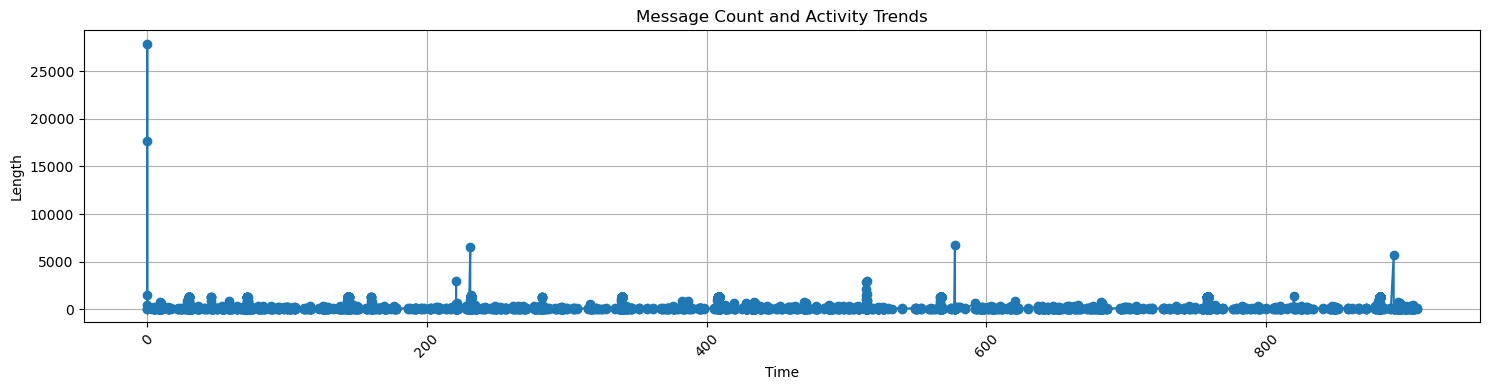

In [13]:
isvalid = True
while isvalid:
    answer = input("Please select which Whatsapp Group you want to clean:\n"
                           "1 - Mixed messages (a bit from everything)\n"
                           "2 - Mostly Images\n"
                           "3 - Mostly Audio\n"
                           "4 - Mostly videos\n"
                           "5 - Mostly Files\n"
                           "6 - Noisy recording\n"
                           "7 - Attacked user active in several groups\n"
                           "8 - Attacker when Attacked user active in several groups\n"
                           "9 - Exit\n")
    if answer != '1' and answer != '2' and answer != '3' and answer != '4' and answer != '5' and answer != '6' and answer != '7' and answer != '8' and answer != '9':
        print("Invalid value. Please enter a valid number\n")
    elif answer == '9':
        isvalid = False
        print("Goodbye")
    else:
        isvalid = False
        df, name = load_csv(answer)
        plot_activity_trends(df)

In [14]:
df

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
0,1.0,0.000000,10.0.2.15,157.240.214.60,TLSv1.2,413.0,Application Data,0.000000,0.0
1,2.0,0.000815,157.240.214.60,10.0.2.15,TCP,60.0,443 > 35260 [ACK] Seq=1 Ack=360 Win=65535 Len=0,0.000815,353.0
2,3.0,0.076831,157.240.214.60,10.0.2.15,TCP,1446.0,"443 > 35260 [PSH, ACK] Seq=1 Ack=360 Win=655...",0.076016,1386.0
3,4.0,0.077251,157.240.214.60,10.0.2.15,TLSv1.2,27894.0,"Application Data, Application Data, Applicatio...",0.000420,26448.0
4,5.0,0.077821,157.240.214.60,10.0.2.15,TLSv1.2,17685.0,"Application Data, Application Data",0.000570,10209.0
...,...,...,...,...,...,...,...,...,...
4400,4401.0,905.548434,10.0.2.15,157.240.214.60,TCP,54.0,59460 > 443 [ACK] Seq=67092 Ack=65310 Win=65...,0.042391,96.0
4401,4402.0,905.558160,10.0.2.15,157.240.214.60,TLSv1.2,149.0,Application Data,0.009725,95.0
4402,4403.0,905.559051,157.240.214.60,10.0.2.15,TCP,60.0,443 > 59460 [ACK] Seq=65310 Ack=67187 Win=65...,0.000891,89.0
4403,4404.0,907.419280,10.0.2.15,157.240.214.60,TLSv1.2,150.0,Application Data,1.860230,90.0


In [15]:
'''protocols that appeared in some recordings, but are not containing messages content:
Elasticsearch: Not a communication protocol but rather a search engine. Elasticsearch operates over HTTP, so the packets might be associated with search queries or indexing operations.
DNS: Domain Name System, used for domain name resolution. its packets doesn't contain message content
SSDP: Simple Service Discovery Protocol, primarily used with UPnP (Universal Plug and Play). It's not related to WhatsApp messages.
HTTP: The foundation of any data exchange on the Web. WhatsApp might use HTTP for certain services, but not likely for message transmission as it would be less secure.
NTP: Network Time Protocol. It's used to synchronize the clocks of computer systems over packet-switched, variable-latency data networks. This would not contain WhatsApp message content.
MDNS: Multicast DNS. Used for resolving hostnames to IP addresses within small networks that do not include a local name server. Not related to WhatsApp message content.
ICMPv6: It's used for diagnostic purposes, error reporting, and other operations related to the management of IP networks.wouldn't contain the content of WhatsApp messages.
NBNS: protocol used on IP networks like the Internet to provide name resolution for NetBIOS over TCP/IP. Thus, doesn't contains data packets.
Thus, we will filter out the rows wherethe protocol is one of the listed above'''

# List of protocols to exclude
protocols_to_exclude = ['Elasticsearch', 'DNS', 'SSDP', 'HTTP', 'NTP', 'MDNS', 'ICMPv6', 'NBNS']

# Filter rows
df = df[~df['Protocol'].isin(protocols_to_exclude)]

In [16]:
protocol_counts = df['Protocol'].value_counts()
print(protocol_counts)

QUIC       1807
TCP        1330
TLSv1.2     910
TLSv1.3     210
Name: Protocol, dtype: int64


In [17]:
# Create a true copy of df
temp_df = df.copy()

# Extract the first number from the "Source" column
temp_df["FirstNumber"] = temp_df["Source"].str.split('.').str[0]

# Group by both FirstNumber, average packet length, and most used protocol
result_df = temp_df.groupby(["FirstNumber"]).agg(
    Count=('Source', 'size'),
    MedianPacketLength=('Length', 'median'),
    MostUsedProtocol=('Protocol', lambda x: x.mode()[0] if not x.mode().empty else None)  # Use mode to find the most frequent protocol
).reset_index()

result = result_df.groupby("FirstNumber").agg(
    TotalCount=('Count', 'sum'),
    OverallMedianPacketLength=('MedianPacketLength', 'median'),
    OverallMostUsedProtocol=('MostUsedProtocol', lambda x: x.mode()[0] if not x.mode().empty else None)
).reset_index()

result = result.sort_values(by='TotalCount', ascending=False).reset_index(drop=True)

print(result)

  FirstNumber  TotalCount  OverallMedianPacketLength OverallMostUsedProtocol
0         157        2153                      219.0                    QUIC
1          10        1926                       77.0                    QUIC
2         142          68                       60.0                     TCP
3         172          52                       66.0                    QUIC
4         216          25                      127.0                    QUIC
5          74          21                       60.0                     TCP
6         185          12                       60.0                     TCP


In [18]:
ip_counts = df['Source'].value_counts()
print(ip_counts)

10.0.2.15          1926
157.240.214.60     1127
157.240.221.60      989
157.240.0.60         37
216.239.38.120       25
142.250.74.202       21
172.217.22.99        21
74.125.133.188       21
172.217.18.110       20
142.250.74.195       19
142.250.184.195      13
142.250.185.69       11
172.217.16.206       11
185.125.190.48        4
185.125.190.18        4
185.125.190.17        4
142.250.181.238       4
Name: Source, dtype: int64


In [19]:
df = df.loc[rows_of_probably_noisy_packets(df)]

In [20]:
sorted_lengths = df['Length'].sort_values(ascending=False).reset_index(drop=True)

# Define threshold number of packets
num_outliers = min(int(len(df) * 0.001), len(df[df['Length'] > 10000]))

# Check the size of the packet just below the threshold
packet_below_threshold = sorted_lengths.iloc[num_outliers]

# If the largest packet is more than 3 times the packet_below_threshold, filter out the outliers
if sorted_lengths.iloc[0] > 3 * packet_below_threshold:
    # Get all the lengths considered outliers
    outlier_lengths = sorted_lengths.head(num_outliers).to_list()
    df = df[~df['Length'].isin(outlier_lengths)]

In [21]:
df

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
0,1.0,0.000000,10.0.2.15,157.240.214.60,TLSv1.2,413.0,Application Data,0.000000,0.0
1,2.0,0.000815,157.240.214.60,10.0.2.15,TCP,60.0,443 > 35260 [ACK] Seq=1 Ack=360 Win=65535 Len=0,0.000815,353.0
2,3.0,0.076831,157.240.214.60,10.0.2.15,TCP,1446.0,"443 > 35260 [PSH, ACK] Seq=1 Ack=360 Win=655...",0.076016,1386.0
5,6.0,0.078524,10.0.2.15,157.240.214.60,TCP,54.0,35260 > 443 [ACK] Seq=360 Ack=46864 Win=6553...,0.000703,17631.0
6,7.0,3.435388,10.0.2.15,157.240.214.60,TLSv1.2,124.0,Application Data,3.356863,70.0
...,...,...,...,...,...,...,...,...,...
4400,4401.0,905.548434,10.0.2.15,157.240.214.60,TCP,54.0,59460 > 443 [ACK] Seq=67092 Ack=65310 Win=65...,0.042391,96.0
4401,4402.0,905.558160,10.0.2.15,157.240.214.60,TLSv1.2,149.0,Application Data,0.009725,95.0
4402,4403.0,905.559051,157.240.214.60,10.0.2.15,TCP,60.0,443 > 59460 [ACK] Seq=65310 Ack=67187 Win=65...,0.000891,89.0
4403,4404.0,907.419280,10.0.2.15,157.240.214.60,TLSv1.2,150.0,Application Data,1.860230,90.0


In [22]:
df = df[~(df['Info'].str.contains('Len=0', case=False, na=False))]

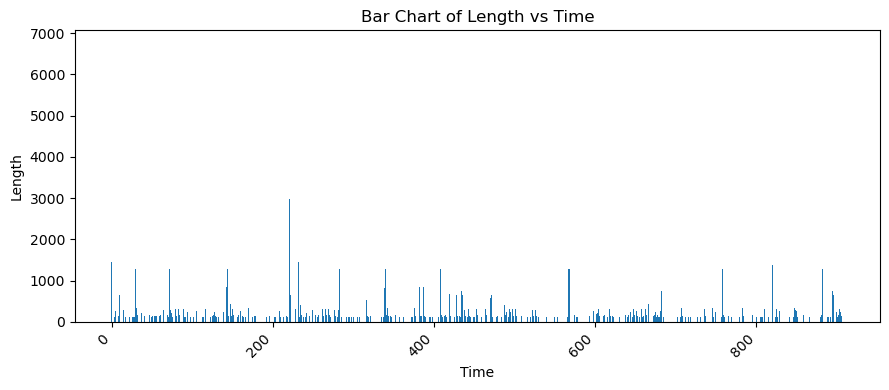

In [23]:
bar_plot(df)

In [24]:
grouped_df = df.groupby('Info').size().reset_index(name='Count')
sorted_df = grouped_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

set(sorted_df['Info'].tolist())

{'0-RTT, DCID=12978cde085f8442',
 '0-RTT, DCID=18500b410e1b1447',
 '0-RTT, DCID=361a6e24570d71ea',
 '0-RTT, DCID=72d3e695fdac2f3b',
 '0-RTT, DCID=853b1700736559e5',
 '0-RTT, DCID=8faf60347454d1ef',
 '0-RTT, DCID=a283a99aef2fdfd1',
 '0-RTT, DCID=e8dcf390ed2720bc',
 '0-RTT, DCID=ec21fa1fd2baa1a7',
 '0-RTT, DCID=f4c5d7fbc78cacd1',
 '443  >  35260 [PSH, ACK] Seq=1 Ack=360 Win=65535 Len=1392 [TCP segment of a reassembled PDU]',
 'Application Data',
 'Application Data, Application Data',
 'Change Cipher Spec',
 'Change Cipher Spec, Application Data',
 'Client Hello',
 'Handshake, DCID=801d01861d0d3de4',
 'Handshake, DCID=811d00a12a81fa48',
 'Handshake, DCID=8c1d0126309026fd',
 'Handshake, DCID=9f1d00620725a81c',
 'Handshake, DCID=9f1d01172477c2fd',
 'Handshake, DCID=9f1d012630e3dccc',
 'Handshake, DCID=9f1d01861d326602',
 'Handshake, DCID=a51d0072099b6c03',
 'Handshake, DCID=ac1d00090d2af918',
 'Handshake, DCID=b51d007209ed5618',
 'Handshake, SCID=801d01861d0d3de4',
 'Handshake, SCID=811d00a

In [25]:
df = df[~df['Info'].str.contains('Initial', case=False, na=False)]
df = df[~(df['Info'].str.contains('Change Cipher Spec', case=False, na=False) & (df['Length'] <= 250))]
df = df[~(df['Info'].str.lower() == 'client hello')]
df = df[~(df['Info'].str.contains('Server Hello', case=False, na=False) & (df['Length'] <= 250))]
cleaned_df = remove_middle_row(df)

In [26]:
df.head(20)

,No.,Time,Source,Destination,Protocol,Length,Info,Time_delay,Length_diff
0,1.0,0.000000,10.0.2.15,157.240.214.60,TLSv1.2,413.0,Application Data,0.000000,0.0
2,3.0,0.076831,157.240.214.60,10.0.2.15,TCP,1446.0,"443 > 35260 [PSH, ACK] Seq=1 Ack=360 Win=655...",0.076016,1386.0
6,7.0,3.435388,10.0.2.15,157.240.214.60,TLSv1.2,124.0,Application Data,3.356863,70.0
8,9.0,4.648562,10.0.2.15,157.240.214.60,TLSv1.2,269.0,Application Data,1.211891,209.0
10,11.0,4.808730,10.0.2.15,157.240.214.60,TLSv1.2,124.0,Application Data,0.159566,64.0
12,13.0,4.860666,157.240.214.60,10.0.2.15,TLSv1.2,165.0,Application Data,0.050176,105.0
14,15.0,5.274762,157.240.214.60,10.0.2.15,TLSv1.2,150.0,Application Data,0.414072,96.0
16,17.0,5.291752,10.0.2.15,157.240.214.60,TLSv1.2,149.0,Application Data,0.016965,95.0
18,19.0,5.459908,157.240.214.60,10.0.2.15,TLSv1.2,151.0,Application Data,0.167488,91.0
19,20.0,5.465250,10.0.2.15,157.240.214.60,TLSv1.2,150.0,Application Data,0.005342,1.0


In [27]:
def cdCleanCsv():
    # Get the current directory where your notebook is located
    current_dir = os.getcwd()

    # Construct the path to the "resources" directory
    resources_dir = os.path.join(current_dir, '..', 'resources')

    # Construct the path to the "CLEAN" directory within "resources"
    CLEAN_dir = os.path.join(resources_dir, 'CLEAN/')
    return CLEAN_dir

In [28]:
work_path = cdCleanCsv()
df.drop(columns=["Time_delay","Length_diff"], inplace=True)
df.to_csv(work_path + name + 'Clean.csv', index=False)